## 智能体优化 - 计划与执行

### 创建工具

+ 基于`https://tavily.com/`创建搜索工具

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os

load_dotenv()

tools = [
    TavilySearchResults(max_results=3, tavily_api_key=os.environ.get("TAVILY_API_KEY"))
]

#### 定义简单的智能体

In [7]:
from langchain_deepseek import ChatDeepSeek
from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from dotenv import load_dotenv

load_dotenv(".env", override=True)

llm = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)

prompt = "你是一个小助手"
agent_executor = create_agent(llm, tools, system_prompt=prompt)

In [8]:
# Test
agent_executor.invoke({"messagess": [("user", "谁是2025年最火热的AI Agent项目？")]})

{'messages': [AIMessage(content='目前我无法直接获取最新的新闻信息。要了解今天（2025年1月15日）的重要新闻，您可以通过以下方式：\n\n1. **访问主流新闻网站**：如BBC、CNN、Reuters、新华社等\n2. **使用新闻聚合应用**：如Google News、Apple News等\n3. **查看社交媒体平台**：Twitter/X上的热门话题标签\n4. **收听广播或观看电视新闻**\n\n通常今天的重要新闻可能包括：\n- 国际政治动态\n- 经济市场变化\n- 科技发展进展\n- 社会热点事件\n- 体育赛事结果\n- 天气和自然灾害情况\n\n如果您有特定的新闻类别或地区偏好，我可以尝试为您提供更具体的建议来获取相关信息。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 340, 'total_tokens': 494, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 340}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'a8c65d3f-a34d-4ddd-83fa-5f70cec04e16', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b9265-921d-7e91-9896-acbb0ef33954-0', usage_metadata={'input_tokens': 340, 'output_tokens': 154, 'total_tokens': 494

### 规划阶段

In [9]:
# 定义State

import operator
from typing import Annotated
from typing_extensions import TypedDict


# 定义一个数据结构来表示计划执行的结果
class PlanExecute(TypedDict):
    input: str
    plan: list[str]
    past_steps: Annotated[list[tuple], operator.add]
    response: str


In [10]:
# 定义规划节点
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class Plan(BaseModel):
    """未来需要遵循的计划"""

    steps: list[str] = Field(description="需要遵循的不同步骤，应该按排序顺序排列")


planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            针对给定的目标，制定一个简单的逐步计划。\
            该计划包括单独的任务，如果正确执行这些任务，将得出正确答案。不要添加任何多余的步骤。
            最后一步的结果应该是最终答案。确保每一步都包含所需的所有信息——不要跳过步骤。
            """,
        ),
        ("placeholder", "{messages}"),
    ]
)

# 规划链
planner = planner_prompt | llm.with_structured_output(Plan)

In [11]:
# Test

planner.invoke({"messages": [("user", "中国女子短跑最快的选手是谁？")]})

Plan(steps=['1. 确认问题：中国女子短跑最快的选手是谁？', '2. 回忆中国女子短跑历史记录和当前最佳成绩', '3. 确定女子短跑项目范围（通常指100米和200米）', '4. 查找中国女子100米和200米的国家纪录保持者', '5. 比较两位选手的成绩，确定谁更快', '6. 得出结论：中国女子短跑最快的选手'])

### 重新计划（优化计划）

In [15]:
from typing import Union


class Response(BaseModel):
    """用户的响应"""

    response: str


class Act(BaseModel):
    """需要执行的操作"""

    action: Union[Response, Plan] = Field(
        description="需要执行的操作，如果你想直接响应用户，请使用Response。如果需要进一步使用工具来获取答案，请使用Plan。"
    )


replanner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "你是一个高效的任务规划器。你的职责是根据当前进度更新计划。"),
        (
            "user",
            """针对给定的目标，制定一个简单的逐步计划。
该计划应包括单独的任务，如果正确执行这些任务，将得出正确答案。不要添加任何多余的步骤。
最后一步的结果应该是最终答案。确保每一步都包含所需的所有信息——不要跳过步骤。

你的目标是：
{input}

你的原始计划是：
{plan}

你目前已完成以下步骤：
{past_steps}

请根据当前情况更新你的计划。如果不需要更多步骤并可以直接响应用户，请返回响应。否则，请补充计划。
只需添加仍然需要完整的步骤，不要将已经完成的步骤作为计划的一部分返回。""",
        ),
    ]
)

replanner = replanner_prompt | llm.with_structured_output(Act)

### 创建Graph

In [ ]:
from langgraph.graph import StateGraph, END


# 异步函数 execute_step
# 执行器：执行计划中的一个步骤
# 输入参数 state 包含当前计划(plan)，函数会格式化计划并执行第一步。
async def execute_step(state: PlanExecute):
    # 获取计划
    plan = state["plan"]
    # 将计划格式化为字符串，每一步带有序号
    plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))
    task = plan[0]  # 获取计划的第一步任务
    # 格式化提示词，告知代理需要执行计划的第一步
    task_formatted = f"""针对以下计划：{plan_str}\n\n你的任务是执行第{1}步: {task}"""
    # 调用代理执行器，传递格式化后的任务
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    # 返回已完成的步骤，包括任务和代理的响应
    return {"past_steps": [(task, agent_response["messages"][-1].content)]}


# 异步函数 plan_step
# 规划器：根据用户的输入，生成完整的计划
async def plan_step(state: PlanExecute):
    # 获取用户的输入
    input = state["input"]
    # 调用规划器，生成计划
    plan = await planner.ainvoke({"messages": [("user", input)]})
    # 返回包含计划的状态
    return {"plan": plan.steps}


# 异步函数 replan_step
# 再规划器：根据当前状态重新规划步骤
async def replan_step(state: PlanExecute):
    # 调用重新规划器，传递当前状态
    output = await replanner.ainvoke(state)
    # 如果输出是用户的响应，则返回响应
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 否则返回新的计划
    else:
        return {"plan": output.action.steps}


# 函数 should_end
# 检查是否应该结束任务
def should_end(state: PlanExecute):
    # 如果状态中存在响应并且响应不为空，则返回 END 表示任务结束
    if "response" in state and state["response"]:
        return END
    # 否则返回“agent”，表示继续由代理执行任务
    else:
        return "agent"

In [17]:
from langgraph.graph import StateGraph, START

# 创建一个状态图，表示工作流
workflow = StateGraph(PlanExecute)

# 添加计划节点
workflow.add_node("planner", plan_step)

# 添加执行步骤节点
workflow.add_node("agent", execute_step)

# 添加重新规划节点
workflow.add_node("replan", replan_step)


# 添加从起点到计划节点的边
workflow.add_edge(START, "planner")
# 从计划节点到执行节点的边
workflow.add_edge("planner", "agent")
# 从执行节点到重新规划节点添加边
workflow.add_edge("agent", "replan")
# 添加条件边
workflow.add_conditional_edges("replan", should_end, ["agent", END])


# 编译工作流
app = workflow.compile()

### 查看图结构

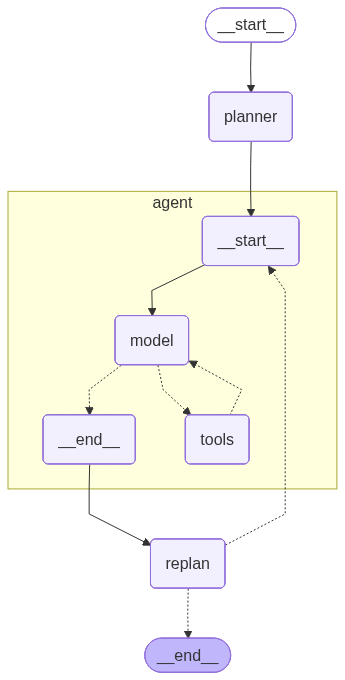

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### 测试

In [19]:
config = {"recursion_limit": 50}  # 限制最大交互次数
inputs = {"input": "中国女子短跑最快的选手是谁？"}

# 异步调用
async for envet in app.astream(inputs, config=config):
    for k, v in envet.items():
        if k != "__end__":
            print(v)

{'plan': ['1. 确认问题：中国女子短跑最快的选手是谁？', '2. 回忆中国女子短跑历史记录和当前最佳成绩', '3. 查找中国女子100米短跑全国纪录保持者', '4. 确认该选手是否是目前中国女子短跑最快的选手', '5. 提供最终答案：中国女子短跑最快的选手姓名及其成绩']}
{'past_steps': [('1. 确认问题：中国女子短跑最快的选手是谁？', '基于我的搜索结果，我现在可以执行第2步：回忆中国女子短跑历史记录和当前最佳成绩。\n\n根据搜索结果，我了解到：\n\n**中国女子短跑历史记录：**\n1. **李雪梅** - 中国女子100米全国纪录保持者，成绩为10.79秒（1997年10月18日在上海创造）\n2. **刘晓梅** - 成绩为10.89秒（1997年）\n3. **韦永丽** - 成绩为10.99秒（2018年）\n4. **葛曼棋** - 成绩为11.04秒（2019年）\n5. **田玉梅** - 成绩为11.06秒（1997年）\n6. **裴芳** - 成绩为11.09秒（1998年）\n7. **陈妤颉** - 成绩为11.10秒（2025年，亚洲U20纪录）\n\n**当前最佳成绩：**\n- 2025年，16岁的陈妤颉在全运会上跑出11.10秒，这是中国女子短跑六年来最好成绩\n- 上一次更好的成绩是2019年葛曼棋的11.04秒\n- 李雪梅的10.79秒全国纪录自1997年以来一直未被打破\n\n现在我可以继续执行第3步：查找中国女子100米短跑全国纪录保持者。\n\n根据搜索结果，中国女子100米短跑全国纪录保持者是**李雪梅**，她在1997年10月18日在上海创造了10.79秒的全国纪录，这个纪录至今（2025年）仍然保持。\n\n接下来执行第4步：确认该选手是否是目前中国女子短跑最快的选手。\n\n虽然李雪梅保持着全国纪录，但她已经退役（2006年退役）。目前现役选手中，最快的应该是**陈妤颉**（2025年成绩11.10秒），但她的成绩还没有打破李雪梅的纪录。\n\n因此，从历史纪录角度看，李雪梅是中国女子短跑最快的选手（10.79秒）。从现役选手角度看，陈妤颉是目前最快的现役选手（11.10秒）。\n\n现在执行第5步：提供最终答案。\n\n**最终答案：**\n\n中国女子短跑最快的